In [6]:
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop, Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization, SeparableConv2D, Input,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import backend as K
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
K.set_image_data_format('channels_first')
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
with open('X_train_1.pkl', 'rb') as file:
    X_train =pickle.load(file)
with open('X_test_1.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_train_1.pkl', 'rb') as file:
    y_train =pickle.load(file)
    
with open('y_test_1.pkl', 'rb') as file:
    y_test =pickle.load(file)

y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)

In [7]:
X_train=X_train.reshape(3875,3,150,150)
X_test=X_test.reshape(390,3,150,150)

In [8]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
filepath="BCNN2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [9]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 37, 37)       

In [10]:
history = model.fit(X_train, y_train,validation_split=0.2 ,callbacks=[lr_reduce,checkpoint] ,
          epochs=7)

Train on 3100 samples, validate on 775 samples
Epoch 1/7
3072/3100 [============================>.] - ETA: 0s - loss: 0.6451 - accuracy: 0.6704
Epoch 00001: val_accuracy improved from -inf to 0.58065, saving model to BCNN2.hdf5
3100/3100 [==============================] - 21s 7ms/sample - loss: 0.6443 - accuracy: 0.6711 - val_loss: 0.6980 - val_accuracy: 0.5806
Epoch 2/7
3040/3100 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.7087
Epoch 00002: val_accuracy improved from 0.58065 to 0.69355, saving model to BCNN2.hdf5
3100/3100 [==============================] - 6s 2ms/sample - loss: 0.5894 - accuracy: 0.7097 - val_loss: 0.6103 - val_accuracy: 0.6935
Epoch 3/7
3072/3100 [============================>.] - ETA: 0s - loss: 0.5794 - accuracy: 0.7235
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_accuracy did not improve from 0.69355
3100/3100 [==============================] - 6s 2ms/sample - loss: 0.5799 - accurac

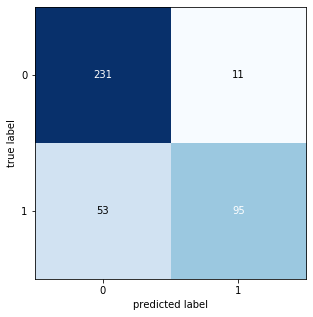

In [12]:
pred = model.predict(X_test)
pred1 = np.argmax(pred,axis = 1) 
y_test1 = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test1, pred1)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

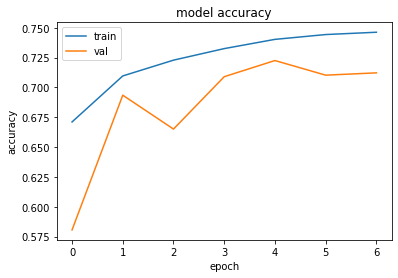

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

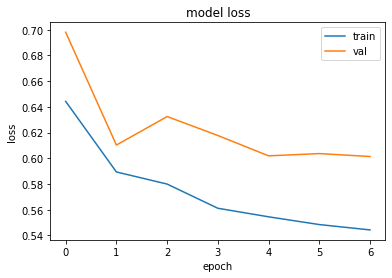

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

In [15]:
print(classification_report(y_test1,pred1))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       242
           1       0.90      0.64      0.75       148

    accuracy                           0.84       390
   macro avg       0.85      0.80      0.81       390
weighted avg       0.84      0.84      0.83       390

